# **Capstone II Modeling**

In this section of the data science method we finally apply machine learning models to answer our original question: 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
df = pd.read_csv('../Data/train_cleaned.csv', parse_dates = ['date_time'], index_col = 'date_time')
df.index = pd.date_range(start = df.index[0], end = df.index[-1], freq='15min')

In [18]:
X = df.drop(columns = 'indoor_temperature_room')
y = df['indoor_temperature_room']

### ARIMA Modeling

Based on the acf and pacf functions viewed in previous in the EDA section, we assume the best model for our data is an ARIMA model of some order. Here we test a variety of combinations of AR, MA, and ARIMA orders to find the best model.

In [24]:
def evaluate_ARMA_model(y, p_values, d_values, q_values):
    
    # Create empty list to store search results
    order_aic_bic=[]

    # Loop over p values
    for p in p_values:
        # Loop over d values
        for d in d_values:
            # Loop over q values
            for q in q_values:
                # create and fit ARMA(p,q) model
                try:
                    model = SARIMAX(y, order=(p, d, q))
                    results = model.fit()
                    order_aic_bic.append((p, d, q, results.aic, results.bic))
                except:
                    pass
                # Append order and results tuple
                order_aic_bic.append((p, d, q, results.aic, results.bic))
    return order_aic_bic

In [25]:
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

In [27]:
thing = evaluate_ARMA_model(y, p, d, q)

C:\Users\metal\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
blod = pd.DataFrame(thing, columns = ['p', 'd', 'q', 'AIC', 'BIC'])

In [31]:
blod.sort_values(by = ['AIC']).head()

,p,d,q,AIC,BIC
47,2,1,2,-8832.860243,-8803.239881
46,2,1,2,-8832.860243,-8803.239881
29,1,1,2,-8811.640369,-8787.944079
28,1,1,2,-8811.640369,-8787.944079
26,1,1,1,-8810.726903,-8792.954686


In [32]:
blod.sort_values(by = ['BIC']).head()

,p,d,q,AIC,BIC
47,2,1,2,-8832.860243,-8803.239881
46,2,1,2,-8832.860243,-8803.239881
26,1,1,1,-8810.726903,-8792.954686
27,1,1,1,-8810.726903,-8792.954686
28,1,1,2,-8811.640369,-8787.944079


In [4]:
model = SARIMAX(df['indoor_temperature_room'], exog = df.drop(columns = 'indoor_temperature_room'),
               order = (0, 1, 1))

In [5]:
res = model.fit()

In [6]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     indoor_temperature_room   No. Observations:                 2764
Model:                    SARIMAX(0, 1, 1)   Log Likelihood                2475.518
Date:                     Sun, 26 Jun 2022   AIC                          -4917.036
Time:                             18:01:33   BIC                          -4816.327
Sample:                         03-13-2012   HQIC                         -4880.659
                              - 04-11-2012                                         
Covariance Type:                       opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
co2_dining_room                  -0.0002      0.001     -0.363      0.716      -0.001       0.001
co2_room                          0.0033      0.000     12.226      0.000       0.003       0.004
relative_humidity_dining_room     0.0298      0.006      4.967      0.000       0.018       0.042
relative_humidity_room           -0.0895      0.007    -12.571      0.000      -0.103      -0.076
lighting_dining_room              0.0009      0.001      1.685      0.092      -0.000       0.002
lighting_room                  6.348e-05      0.000      0.172      0.864      -0.001       0.001
rain                              0.0363      0.039      0.925      0.355      -0.041       0.113
sun_dusk                      -6.103e-05   7.27e-05     -0.840      0.401      -0.000    8.15e-05
wind                              0.0210      0.005      3.961      0.000       0.011       0.031
sun_light_in_west_facade       2.077e-06   5.76e-07      3.604      0.000    9.48e-07    3.21e-06
sun_light_in_east_facade      -8.903e-06   4.65e-07    -19.162      0.000   -9.81e-06   -7.99e-06
sun_light_in_south_facade       -1.8e-06   1.19e-06     -1.518      0.129   -4.12e-06    5.25e-07
sun_irradiance                    0.0002      0.000      1.817      0.069    -1.7e-05       0.000
outdoor_relative_humidity        -0.0412      0.002    -20.027      0.000      -0.045      -0.037
day_of_the_week                   0.0047      0.013      0.348      0.728      -0.022       0.031
ma.L1                             0.5284      0.024     22.192      0.000       0.482       0.575
sigma2                            0.0138      0.000     29.280      0.000       0.013       0.015
===================================================================================
Ljung-Box (L1) (Q):                 465.68   Jarque-Bera (JB):              1241.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
forecast = res.get_prediction(start = -25)
mean_forecast = forecast.predicted_mean

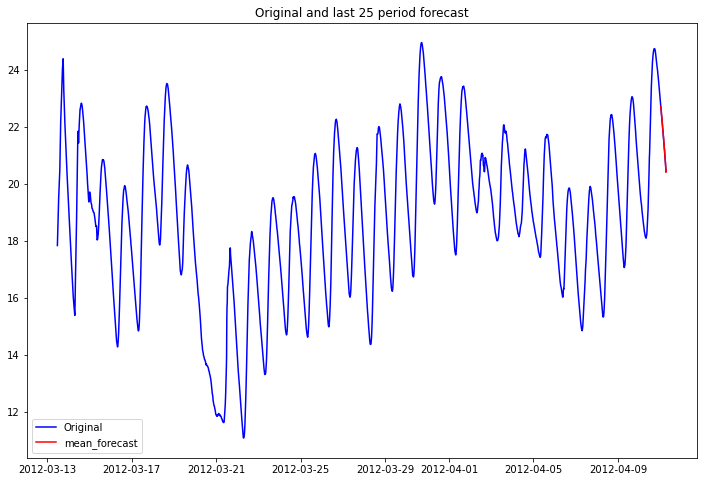

In [8]:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(df['indoor_temperature_room'], color='blue',label='Original')
forecasted_mean = plt.plot(mean_forecast, color='red', label = 'mean_forecast')
plt.legend(loc='best')
plt.title('Original and last 25 period forecast')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [ ]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast(len(test))
    # calculate out of sample error
    error = mean_squared_error(test,future)
    # Return the error
    return error

In [ ]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p , d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    print('mse',mse)

                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except KeyboardInterrupt:
                    break
                except Exception as e:
                    print('failed!', e)
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [13]:
# Now, we choose a couple of values to try for each parameter.
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

In [ ]:
evaluate_models(train['indoor_temperature_room'], p, d, q)

In [ ]:
model = ARIMA(y[:-5], order = (2,0, 1))
model_fit = model.fit()
future = model_fit.forecast(5)

In [ ]:
print( list(zip(y[:-5], future)))
print(np.mean([ (i[0] - i[1] )**2 for i in list(zip(y[:-5], future))]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
split = int(len(X)*0.8)
df_train = X.iloc[:split]
y_train = y[:split]

columns = ['co2_dining_room', 'co2_room', 'relative_humidity_dining_room',
       'relative_humidity_room', 'lighting_dining_room', 'lighting_room',
       'rain', 'sun_dusk', 'wind', 'sun_light_in_west_facade',
       'sun_light_in_east_facade', 'sun_light_in_south_facade',
       'sun_irradiance', 'outdoor_relative_humidity', 'day_of_the_week']
clf.fit(df_train[columns].values, y_train)

In [ ]:
clf.predict(X.iloc[split:][columns].values)

In [ ]:
np.mean([ (i[0] - i[1])**2 for i in  zip(y[split:], clf.predict(X.iloc[split:][columns].values))])

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y, label='observed data', color = 'blue')
plt.plot(model_fit.predict(), color = 'red', label='modeled data')
plt.title('Observed and modeled cigarette sales over time')
plt.xlabel('Year')
plt.ylabel('Cigarette sales (log scaled)')
plt.legend(loc = 'best')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['indoor_temperature_room'], order = (0, 1, 1))

In [ ]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(y, order=(38, 0, 0))
res = model.fit()

res.params

In [ ]:
pred = res.predict(start='2012-04-11 04:15:00', end='2012-04-11 06:30:00')
pred.plot()

In [ ]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(df['indoor_temperature_room'], order=(38, 0, 0))
res = model.fit()

res.params